In [24]:
#Setup and Installation
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [5]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)

Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


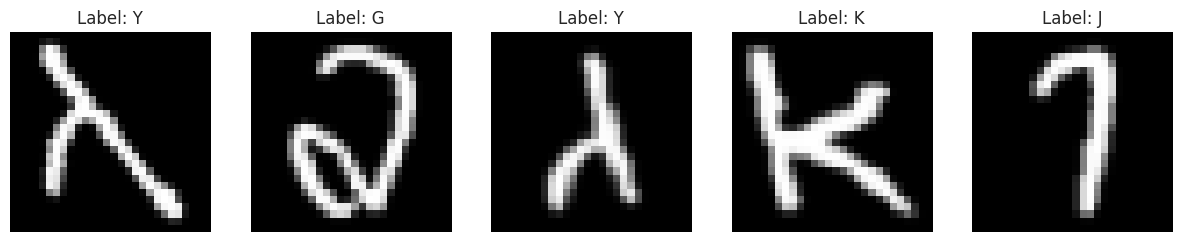

In [16]:
#Data Loading and Preprocessing
# Load EMNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True,
)

def ds_to_numpy(ds):
    images = []
    labels = []
    for img, label in tfds.as_numpy(ds):
        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

x_train, y_train = ds_to_numpy(ds_train)
x_test, y_test = ds_to_numpy(ds_test)


# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    #Rotate image to the correct orientation
    img = np.flip(np.squeeze(x_train[i]).T, axis=0)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [17]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for dense layers
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (71040, 784)
Preprocessed validation data shape: (17760, 784)
Preprocessed test data shape: (14800, 784)


In [20]:
#Model implementation
def create_simple_nn(input_shape, num_classes):
    """
    Create a simple neural network for EMNIST classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 80% accuracy on test set
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (784,) for flattened 28x28 images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = input_shape),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
           
    ])
    
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(784,), num_classes=26)
model.summary()

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,930 (2.06 MB)

 Trainable params: 539,930 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
  23/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9451 - loss: 0.1538

2025-05-13 01:50:17.616825: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 222781440 exceeds 10% of free system memory.


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9415 - loss: 0.1618

2025-05-13 01:50:28.235254: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55695360 exceeds 10% of free system memory.


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9415 - loss: 0.1618 - val_accuracy: 0.9203 - val_loss: 0.2704 - learning_rate: 4.0000e-05
Epoch 2/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9397 - loss: 0.1615 - val_accuracy: 0.9206 - val_loss: 0.2700 - learning_rate: 4.0000e-05
Epoch 3/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9414 - loss: 0.1581 - val_accuracy: 0.9213 - val_loss: 0.2692 - learning_rate: 4.0000e-05
Epoch 4/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9429 - loss: 0.1535 - val_accuracy: 0.9206 - val_loss: 0.2692 - learning_rate: 4.0000e-05
Epoch 5/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9427 - loss: 0.1511 - val_accuracy: 0.9202 - val_loss: 0.2712 - learning_rate: 4.0000e-05
Epoch 6/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9449 - loss: 0.1491 - val_accuracy: 0.9207 - val_loss: 0.2720 - learning_rate: 4.0000e-05
Epoch 7/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - 

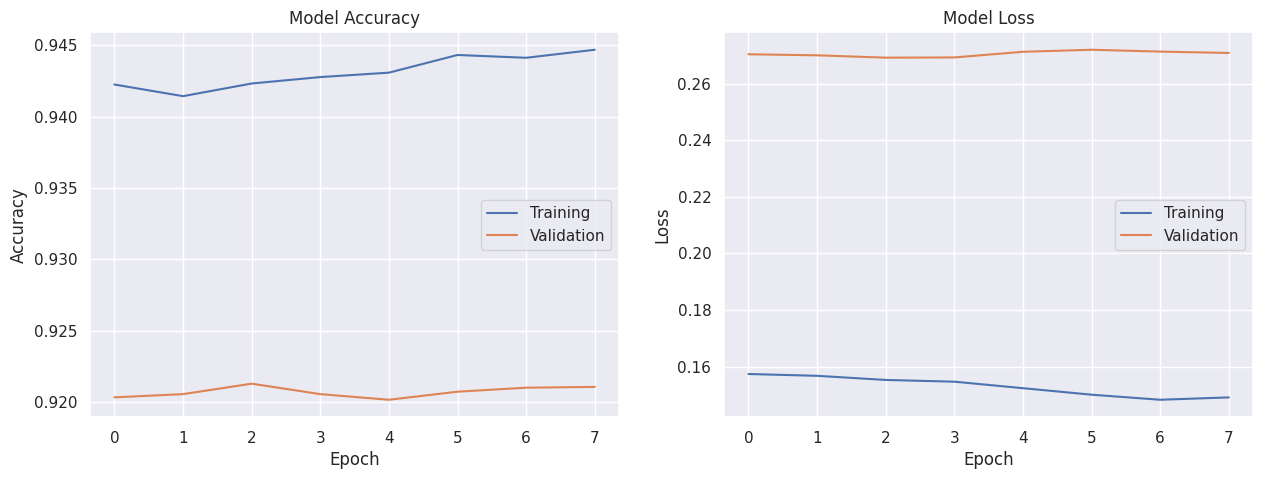

In [ ]:
#Training and Evolution

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9100 - loss: 0.3085
Test accuracy: 0.9087
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


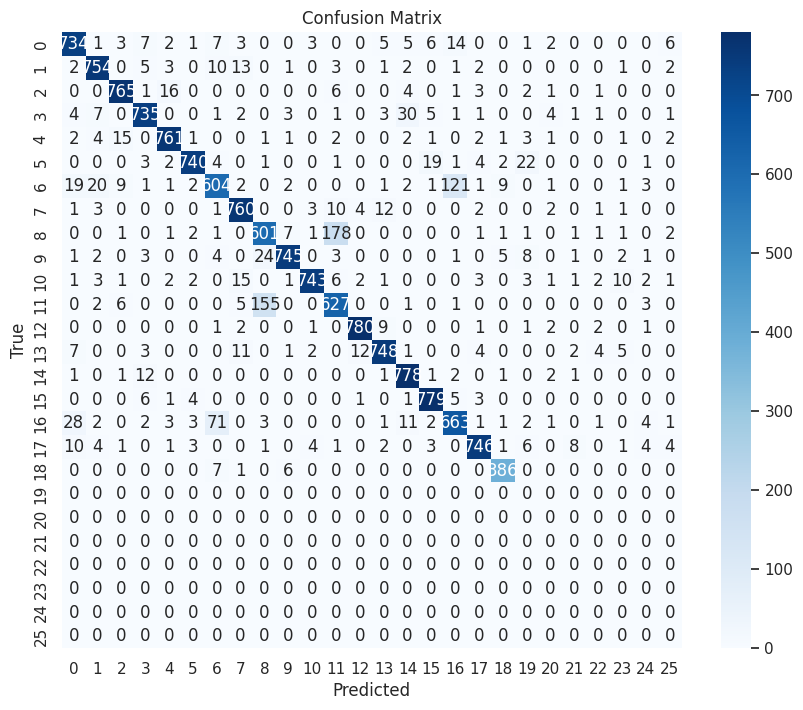

{'model': 'emnist_classifier', 'accuracy': 0.9087162017822266, 'precision': 0.6720264426368481, 'recall': 0.6651442307692308, 'f1_score': 0.6683367769999662, 'confusion_matrix': [[734, 1, 3, 7, 2, 1, 7, 3, 0, 0, 3, 0, 0, 5, 5, 6, 14, 0, 0, 1, 2, 0, 0, 0, 0, 6], [2, 754, 0, 5, 3, 0, 10, 13, 0, 1, 0, 3, 0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2], [0, 0, 765, 1, 16, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 1, 3, 0, 2, 1, 0, 1, 0, 0, 0], [4, 7, 0, 735, 0, 0, 1, 2, 0, 3, 0, 1, 0, 3, 30, 5, 1, 1, 0, 0, 4, 1, 1, 0, 0, 1], [2, 4, 15, 0, 761, 1, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 0, 2, 1, 3, 1, 0, 0, 1, 0, 2], [0, 0, 0, 3, 2, 740, 4, 0, 1, 0, 0, 1, 0, 0, 0, 19, 1, 4, 2, 22, 0, 0, 0, 0, 1, 0], [19, 20, 9, 1, 1, 2, 604, 2, 0, 2, 0, 0, 0, 1, 2, 1, 121, 1, 9, 0, 1, 0, 0, 1, 3, 0], [1, 3, 0, 0, 0, 0, 1, 760, 0, 0, 3, 10, 4, 12, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0], [0, 0, 1, 0, 1, 2, 1, 0, 601, 7, 1, 178, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2], [1, 2, 0, 3, 0, 0, 4, 0, 24, 745, 0, 3, 0, 0, 0, 0, 1, 0, 5, 8, 0, 

In [ ]:
#Evaluate model

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

